In [1]:
# load packages
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
import time
# define dimensionality
data_dim=2
torch.set_default_dtype(torch.float)
torch.set_default_device('cpu')

def normalise_data(data):
    ms=torch.mean(data,0)
    stds=torch.std(data,0)+1e-60
    normed_data=(data-ms.repeat(N_data,1))/stds.repeat(N_data,1)
    return normed_data,ms,stds

# define dedicated detector D(z)
net_width=100
# network structure
class In_Out_Discirminator(torch.nn.Module):
    def __init__(self):
        super(In_Out_Discirminator, self).__init__()

        self.linear1 = torch.nn.Linear(data_dim, net_width)
        self.activation1 = torch.nn.ReLU()
        
        self.linear2 = torch.nn.Linear(net_width, net_width)
        self.activation2 = torch.nn.ReLU()

        self.linear3 = torch.nn.Linear(net_width, net_width)
        self.activation3 = torch.nn.ReLU()
        
        self.linear4 = torch.nn.Linear(net_width, net_width)
        self.activation4 = torch.nn.ReLU()
        
        self.linear5 = torch.nn.Linear(net_width, 1)
        self.activation5 = torch.nn.Sigmoid()
    
    def forward(self, x):
        x1 = self.linear1(x)
        x1 = self.activation1(x1)
        
        x2 = self.linear2(x1)
        x2 = self.activation2(x2)

        x3 = self.linear3(x2)
        x3 = self.activation3(x3)

        x4 = self.linear4(x3)
        x4 = self.activation4(x4+x2)

        x5 = self.linear5(x4)
        x5 = self.activation5(x5)
        return x5
        
D=In_Out_Discirminator()
# use SGD optimiser
opt_D= torch.optim.SGD(D.parameters(),lr=0.001, weight_decay=1e-6)

# loss functions
def loss_D_in(data):
    return torch.mean(-torch.log(D(data)+1e-10))
    
def loss_D_out(OOD):
    return torch.mean(-torch.log(-(D(OOD)-1)+1e-10))

# define the calculations used in PGBS:

# batched jacobian calculation
def Jacobian_matrices(input):
    J = torch.vmap(torch.func.jacrev(D))(input)
    return J.detach()
# batched hessian calculation
def Hessian_matrices(input):
    H = torch.vmap(torch.func.hessian(D))(input).reshape((len(input),data_dim,data_dim))
    return H.detach()
# batched log normed derivative: log|dD(x)/dx|
def log_density(input):
    J = Jacobian_matrices(input)[:,0,:]
    return 0.5*(J.pow(2).sum(dim=1)+1e-10).log().unsqueeze(1)
# batched derivative of the log normed derivative: dlog|dD(x)/dx|/dx
def grad_log_density(input):
    J = Jacobian_matrices(input)
    H = Hessian_matrices(input)
    return (torch.matmul(J,H)/torch.matmul(J,J.permute([0,2,1])))[:,0,:]


# prepare data
# load IND latent vectors
raw_data=torch.load("z_IND.pt").detach()
N_data=len(raw_data)

# normalise data (can be omitted)
data,ms,stds=normalise_data(raw_data)
torch.save(ms,"ms.pt")
torch.save(stds,"stds.pt")
D_name="z_IND"

In [2]:
# Step 1 train dedicated detector using IND vectors and trivial OOD samples
batchsize=50
epoch=10000
for e in range(0,epoch):
    # sample in-domain data
    permutation=np.random.permutation(N_data)[0:batchsize]
    #selected_ind_data=data[permutation,:]
    selected_ind_data=data[permutation,:]#+0.1*torch.randn(data[permutation,:].size())
    # sample trivial ood data from uniform distribution
    # this uniform distribution should be "wide" enough
    trivial_OOD=100*(torch.rand(batchsize,data_dim)-0.5)
    # losses
    L_in=loss_D_in(selected_ind_data)
    L_out=loss_D_out(trivial_OOD)
    # total loss
    Loss=L_in+L_out
    # update parameters
    # zero grad
    opt_D.zero_grad()
    # backward
    Loss.backward()
    # upgrad
    opt_D.step()
    # print losses
    if (e%100==0):
        print(round(L_in.item(),4),end="-")
        print(round(L_out.item(),4),end="  ")

torch.save(D,"D_"+D_name+".pt")

0.7335-1.5768  0.7603-0.0424  0.7153-0.0395  0.6398-0.0282  0.5838-0.0591  0.5404-0.0531  0.4813-0.03  0.4449-0.0164  0.4013-0.0345  0.3489-0.0481  0.3185-0.0581  0.2824-0.0199  0.2483-0.0336  0.2247-0.0304  0.2044-0.0169  0.1786-0.0512  0.1648-0.0724  0.1482-0.0144  0.128-0.0647  0.1212-0.0415  0.1074-0.0347  0.102-0.0145  0.0903-0.0175  0.0883-0.0326  0.0752-0.0062  0.073-0.0867  0.0727-0.0213  0.0675-0.0062  0.0639-0.0185  0.0576-0.0094  0.0526-0.1038  0.0535-0.0107  0.0484-0.0233  0.0419-0.0008  0.0465-0.0205  0.043-0.0496  0.0439-0.0093  0.0353-0.0001  0.0363-0.0074  0.0401-0.0918  0.0372-0.0171  0.0334-0.0006  0.0389-0.0  0.0349-0.0039  0.0249-0.0592  0.0275-0.1108  0.0317-0.0003  0.0235-0.0234  0.0341-0.0009  0.0232-0.0205  0.0225-0.0131  0.0334-0.0024  0.0253-0.0002  0.0252-0.0041  0.0223-0.0029  0.0246-0.0015  0.0283-0.0001  0.0201-0.0125  0.0243-0.0012  0.0165-0.0785  0.0183-0.0248  0.0224-0.0424  0.0191-0.0889  0.019-0.0581  0.0198-0.0042  0.0161-0.0831  0.0217-0.0075  0.013

In [3]:
# define function of OGBS algorithm
def PGBS_LMC(data,
             N_iter=150,
             N_chain=500,
             L_MCMC=2000,
             ϵ=0.001,
             T=1/3,
             retain=0.8,
             σ_aug=0.01,
             σ_background=100,
             background_type='uniform',
             λ_background=1,
             λ_boundary=0.5,
             D_name="mnist"
            ):
    # print all hyper parameters
    print("N_iter:", N_iter, ";"
          "N_chain:", N_chain,";"
          "L_MCMC:",  L_MCMC, ";"
          "ϵ:",       ϵ, ";"
          "T:",       T, ";"
          "retain:",  retain, ";"
          "σ_aug:",   σ_aug,  ";"
          "σ_background:" ,  σ_background,   ";"
          "background_type:",background_type,";"
          "λ_background:",   λ_background,   ";"
          "λ_boundary:",     λ_boundary,     ";"
          "D_name:",  D_name)
    #=======
    N_data,data_dim=data.size()
    # optimization starts
    l_LMC=L_MCMC
    X_boundary=torch.zeros(l_LMC,N_chain,data_dim) # tensor to store extracted samples
    x_b=torch.zeros(N_chain,data_dim) # current states
    energies=torch.zeros(N_chain,l_LMC) # energies of current states
    # start
    for Rd in range(0,N_iter):
        print()
        print("Iteration:",Rd)
        check_point_1=time.time()
        # select starting points from in-domain data
        permutation=torch.randperm(N_data)[0:N_chain]
        x_b = data[permutation,:]
        # run Langevin Dynamics
        for e in range(0,l_LMC):
            # print
            if (e%(l_LMC//20)==0):
                print(e,end="-")
                print(log_density(x_b[0:1,:]).detach(),end="-")
                print((D(x_b[0:1,:])).detach()[0])
            # update x_b
            # calculate update
            update = ϵ*grad_log_density(x_b)+torch.randn(x_b.size())*math.sqrt(2*ϵ)*T  
            # propose new states
            propose = x_b + update
            # Metropolis-Hastings step
            u = torch.rand(N_chain,1) # random variable
            E_proposed = log_density(propose)
            E_prev = log_density(x_b)
            α = torch.exp((E_proposed-E_prev)/T) # density ratio
            if_accept = (u < α).float() 
            p = torch.Tensor.repeat(if_accept.reshape(-1,1),(1,data_dim))
            # update states and record
            x_b = x_b + p*update
            X_boundary[e,:,:] = x_b[:,:]
            energies[:,e]=(E_proposed*p+(-p+1)*E_prev)[:,0]

        full_len=l_LMC
        half_len=int(full_len/2)
        # memory mechanism
        if Rd==0: # create buffer
            second_half=X_boundary[half_len:full_len,:,:]
            s=second_half.size()
            X_buffer=second_half.reshape((s[0]*s[1]),data_dim)
        else: # append buffer using the second half of X_boundary
            second_half=X_boundary[half_len:full_len,:,:]
            s=second_half.size()
            X_buffer=torch.cat((second_half.reshape((s[0]*s[1]),data_dim),\
                                       X_buffer),0) 
        #print(X_boundary_data)
        # randomly retain 80% of the whole buffer
        L_buffer=len(X_buffer)
        permutation=torch.randperm(L_buffer)[0:int(L_buffer*retain)]
        retained_part=X_buffer[permutation,:]
        X_buffer=retained_part
        # train D on in-domain data, trivial OOD and 
            # extracted samples to upgrad the boundary
        # random select a part of samples from buffer
        permutation=torch.randperm(len(X_buffer))[0:min(500000,len(X_buffer))]
        boundary_data=X_buffer[permutation,:]
        N_in_data=N_data
        batchsize=50
        N_iter=5000 # update for 5000 updates
        for e in range(0,N_iter):
            # sample in-domain data
            permutation=np.random.permutation(N_in_data)[0:batchsize]
            selected_ind_data=data[permutation,:]+σ_aug*torch.randn(data[permutation,:].size())
            # sample trivial ood data from uniform distribution
            if background_type=='uniform':
                trivial_OOD=σ_background*(torch.rand(batchsize,data_dim)-0.5)
            if background_type=='gaussian':
                permutation=np.random.permutation(N_data)[0:batchsize]
                trivial_OOD=data[permutation,:]+σ_background*torch.randn(data[permutation,:].size())
            # sample from extracted samples
            permutation=torch.randperm(len(boundary_data))[0:batchsize]
            boundary_OOD=boundary_data[permutation,:]
            # losses
            L_in=loss_D_in(selected_ind_data)
            L_background=loss_D_out(trivial_OOD)
            L_boundary=loss_D_out(boundary_OOD)
            # total loss
            Loss=L_in+λ_background*L_background+λ_boundary*L_boundary
            # update parameters
            # zero grad
            opt_D.zero_grad()
            Loss.backward()
            # upgrad
            opt_D.step()
            # print loses
            if (e%1000==0):
                print(round(L_in.item(),4),end="-")
                print(round(L_background.item(),4),end="-")
                print(round(L_boundary.item(),4))
        print("check point")
        time.sleep(0.1)
        # save model
        torch.save(D,"D_"+D_name+".pt")
        print("D saved")
        check_point_2=time.time()
        elapsed_time=check_point_2-check_point_1
        print("elapsed_time:",elapsed_time)

        pred=(D(data).detach()>0.5).float().mean()
        print("p>0.5=",pred)
        if pred<0.90:
            print("stopping criteria met")
            return X_buffer
    return X_buffer

In [4]:
# run boundary sampler to iteratively refine D(x) and pb(z)
boundary_samples=PGBS_LMC(data,
         50,# N_iter
         50,  # N_chain
         2000,# L_MCMC
         0.001,# stepsize
         1,  # T
         0.8,  # retain
         0.0,  # σ_aug
         100,  # σ_background 10 or 100
         'uniform', # background_type 'gaussian' or 'uniform'
         1,    # λ_background
         0.01,    # λ_boundary
         D_name # D_name
            )

N_iter: 50 ;N_chain: 50 ;L_MCMC: 2000 ;ϵ: 0.001 ;T: 1 ;retain: 0.8 ;σ_aug: 0.0 ;σ_background: 100 ;background_type: uniform ;λ_background: 1 ;λ_boundary: 0.01 ;D_name: z_IND

Iteration: 0
0-tensor([[-6.1892]])-tensor([0.9963])
100-tensor([[-4.3007]])-tensor([0.9916])
200-tensor([[-3.8527]])-tensor([0.9823])
300-tensor([[-3.3451]])-tensor([0.9780])
400-tensor([[-2.7547]])-tensor([0.9553])
500-tensor([[-2.1693]])-tensor([0.9208])
600-tensor([[-1.6954]])-tensor([0.8718])
700-tensor([[-1.3563]])-tensor([0.8046])
800-tensor([[-1.4208]])-tensor([0.8313])
900-tensor([[-1.0754]])-tensor([0.7326])
1000-tensor([[-0.8747]])-tensor([0.5936])
1100-tensor([[-1.2152]])-tensor([0.7984])
1200-tensor([[-0.8480]])-tensor([0.5482])
1300-tensor([[-0.8504]])-tensor([0.4295])
1400-tensor([[-0.8374]])-tensor([0.6132])
1500-tensor([[-1.0661]])-tensor([0.7509])
1600-tensor([[-1.1810]])-tensor([0.7711])
1700-tensor([[-0.9367]])-tensor([0.5225])
1800-tensor([[-1.2414]])-tensor([0.7095])
1900-tensor([[-1.2500]])-t

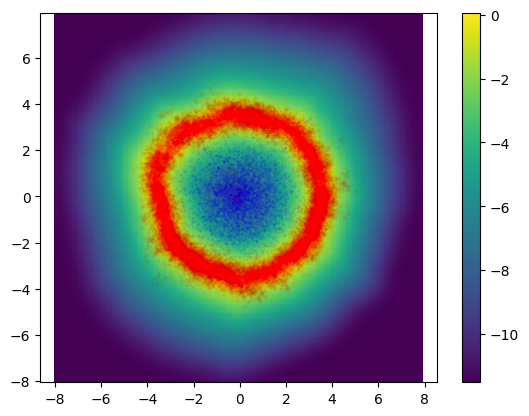

In [6]:
# visualise the boundary pb(z) and samples from that boundary
R=8
xs=torch.arange(-R,R,0.1)
ys=torch.arange(-R,R,0.1)
test_inputs=[]
for i in range(0,len(xs)):
    for j in range(0,len(ys)):
        temp=torch.zeros(data_dim)
        temp[0]=xs[i]
        temp[1]=ys[j]
        test_inputs.append(temp)
inputs=torch.stack(test_inputs)
outputs=log_density(inputs).detach()
plt.clf()
plt.pcolormesh(xs,ys,torch.reshape(outputs,(len(xs),len(ys))).t().numpy())
plt.colorbar()
plt.scatter(data[:,0],data[:,1],s=1,alpha=0.05,c='b');
plt.scatter(boundary_samples[:,0],boundary_samples[:,1],s=1,alpha=0.01,c='r');
#plt.scatter(x_IND_rec[:,0],x_IND_rec[:,1],s=1,alpha=0.5,c='r');
plt.axis("equal");

In [7]:
# save boundary samples
torch.save(boundary_samples,"boundary_samples.pt")